#### <b>Prepare Source Codes</b>

* Reference: https://github.com/genforce/interfacegan

In [1]:
!git clone https://github.com/ndb796/interfacegan
%cd interfacegan

Cloning into 'interfacegan'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 11.39 MiB | 41.50 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/interfacegan


#### <b>Prepare the Pre-trained StyleGAN Model</b>

* Reference: https://github.com/NVlabs/stylegan
* Load PyTorch model weights.

In [2]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1 -O ./models/pretrain/stylegan_celebahq.pth

--2021-03-13 20:33:32--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfdlZTdE5tb0w4X0RyOWJqRUIzUjcxZnFtdzdHVTFvcUxWZ19ZTm5BP3J0aW1lPXAwV2xSVl9tMkVn [following]
--2021-03-13 20:33:33--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfd

* You can change the model settings in the <b>model_settings.py</b> file.

In [3]:
from models.model_settings import MODEL_POOL
from models.model_settings import STYLEGAN_TRUNCATION_PSI
from models.model_settings import STYLEGAN_TRUNCATION_LAYERS
from models.model_settings import STYLEGAN_RANDOMIZE_NOISE

print(list(MODEL_POOL))
print(STYLEGAN_TRUNCATION_PSI)
print(STYLEGAN_TRUNCATION_LAYERS)
print(STYLEGAN_RANDOMIZE_NOISE)

['pggan_celebahq', 'stylegan_celebahq', 'stylegan_ffhq']
1.0
8
False


#### <b>Generate Latent Vector Dataset</b>

* Although you set the latent space type to the 'Z' space, the <b>w.npy</b> will be also generated.

In [4]:
import os.path
import cv2
import imutils
import numpy as np

from tqdm import tqdm
from types import SimpleNamespace
from collections import defaultdict


args = SimpleNamespace()
args.model_name = 'stylegan_celebahq'
args.output_dir = './output/'
args.num = 80000
args.latent_space_type = 'Z'
args.generate_style = True
args.generate_image = True

In [5]:
from models.stylegan_generator import StyleGANGenerator
from utils.logger import setup_logger


logger = setup_logger(args.output_dir, logger_name='generate_dataset')
logger.info(f'Initializing generator.')
gan_type = MODEL_POOL[args.model_name]['gan_type']
if gan_type == 'stylegan':
    model = StyleGANGenerator(args.model_name, logger)
    kwargs = {'latent_space_type': args.latent_space_type}
else:
    raise NotImplementedError(f'Not implemented GAN type `{gan_type}`!')

[2021-03-13 20:34:23,807][INFO] Initializing generator.
[2021-03-13 20:34:24,110][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2021-03-13 20:34:24,504][INFO] Successfully loaded!
[2021-03-13 20:34:24,510][INFO]   `lod` of the loaded model is 0.0.


In [6]:
logger.info(f'Preparing latent codes.')
logger.info(f'  Sample latent codes randomly.')
latent_codes = model.easy_sample(args.num, **kwargs)

total_num = latent_codes.shape[0]
logger.info(f'Generating {total_num} samples.')

results = defaultdict(list)
pbar = tqdm(total=total_num, leave=False)
for latent_codes_batch in model.get_batch_inputs(latent_codes):
    if gan_type == 'stylegan':
        outputs = model.easy_synthesize(latent_codes_batch, **kwargs,
                                        generate_style=args.generate_style,
                                        generate_image=args.generate_image)
    for key, val in outputs.items():
        if key == 'image':
            for image in val:
                save_path = os.path.join(args.output_dir, f'{pbar.n:06d}.jpg')
                image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(save_path, image[:, :, ::-1])
                pbar.update(1)
        else:
            results[key].append(val)
    if 'image' not in outputs:
        pbar.update(latent_codes_batch.shape[0])
    if pbar.n % 1000 == 0 or pbar.n == total_num:
        logger.debug(f'  Finish {pbar.n:6d} samples.')
pbar.close()

logger.info(f'Saving results.')
for key, val in results.items():
    save_path = os.path.join(args.output_dir, f'{key}.npy')
    np.save(save_path, np.concatenate(val, axis=0))

[2021-03-13 20:34:36,723][INFO] Preparing latent codes.
[2021-03-13 20:34:36,727][INFO]   Sample latent codes randomly.
[2021-03-13 20:34:38,461][INFO] Generating 80000 samples.


[2021-03-13 22:08:15,800][INFO] Saving results.


#### <b>Latent Vectors Visualization</b>

In [7]:
from IPython.display import Image

dlatents_w = np.load(args.output_dir + "w.npy")
# dlatents_wp = np.load(args.output_dir + "wp.npy")

print(dlatents_w.shape)
# print(dlatents_wp.shape)

(80000, 512)


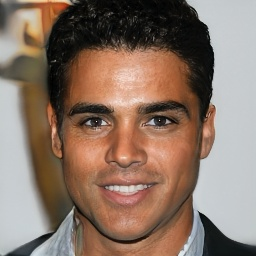

In [11]:
Image('./output/000003.jpg')

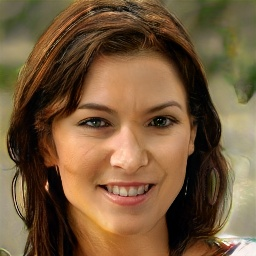

In [13]:
Image('./output/000007.jpg')

In [14]:
import torch
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

In [15]:
class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image


synthesizer = model.model.synthesis
truncator = model.model.truncation
post_process = PostSynthesisProcessing()

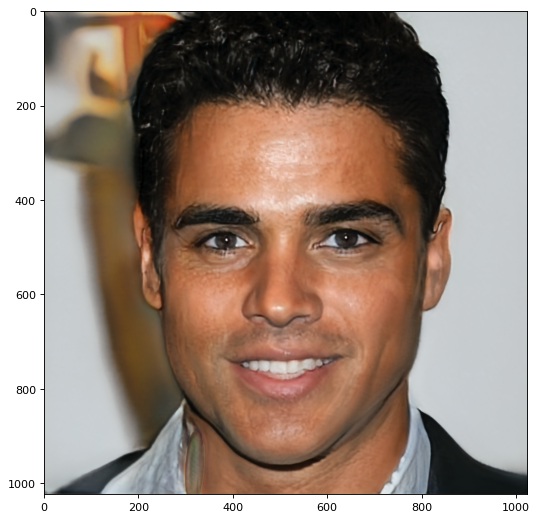

In [17]:
wp = truncator(torch.from_numpy(dlatents_w[3]).unsqueeze(0).cuda()).expand(1, 18, 512)
result = synthesizer(wp)
result = post_process(result).permute(0, 2, 3, 1).detach().cpu().numpy() / 255

plt.imshow(result[0])
plt.show()

In [ ]:
"""
wp = torch.from_numpy(dlatents_wp[1]).unsqueeze(0).cuda()
result = synthesizer(wp)
result = post_process(result).permute(0, 2, 3, 1).detach().cpu().numpy() / 255

plt.imshow(result[0])
plt.show()
"""

#### <b>Image Interpolation</b>

In [18]:
import torchvision
from torchvision.utils import save_image
from torchvision import transforms


def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()

[ Interpolation ]


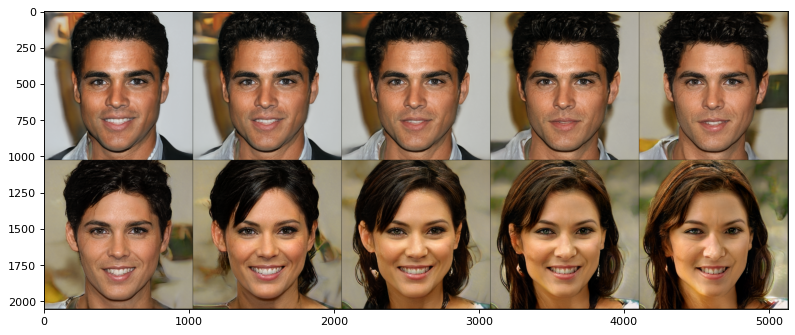

In [20]:
wp_1 = truncator(torch.from_numpy(dlatents_w[3]).unsqueeze(0).cuda()).expand(1, 18, 512)
wp_2 = truncator(torch.from_numpy(dlatents_w[7]).unsqueeze(0).cuda()).expand(1, 18, 512)

print('[ Interpolation ]')

name = 'interpolation'
interpolated_images = []

with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        wp = (1 - alpha) * wp_1 + alpha * wp_2
        image = synthesizer(wp)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

#### <b>Save Processed Dataset</b>

In [21]:
dlatents_w = np.load(args.output_dir + "w.npy")
# print(dlatents_w[0])

dlatents_w_truncated = truncator(torch.from_numpy(dlatents_w).cuda())[:, 0, :].expand(-1, 512)
# print(dlatents_w_truncated[0])

dlatents_w_truncated = dlatents_w_truncated.cpu().numpy()
# print(dlatents_w_truncated[0])

np.save(args.output_dir + "w_truncated.npy", dlatents_w_truncated)

In [22]:
!rm output/style*.npy
!rm output/wp.npy
!ls -al output/*.npy

-rw-r--r-- 1 root root 163840128 Mar 13 22:08 output/w.npy
-rw-r--r-- 1 root root 163840128 Mar 13 22:12 output/w_truncated.npy
-rw-r--r-- 1 root root 163840128 Mar 13 22:08 output/z.npy


In [23]:
%%capture
!zip -r output.zip ./output/

In [24]:
from google.colab import drive

drive.mount('/content/mnt')

Mounted at /content/mnt


In [25]:
!cp output.zip /content/mnt/MyDrive/StyleGANCelebALatentVectorDatasetTruncation100.zip